<img src="logo-2020.png" alt="frankfurt school hmi" style="width: 160px;"/>

# Machine Learning I.
## Problem Set 3:  Time Series Movement Prediction, Feature Engineering, and Model Comparison (14 points total)

### Instructions
The graded portion of problem set 1 consists of one notebook:
```
ps3_nb1-ml.ipynb
```

### Due Date
* Group D: 04-MAR-2020 before 23:59:59 (CET)

### Instructor
* Prof. Dr. Gregory Wheeler ([gregorywheeler.org](http://gregorywheeler.org))

---

### Declare your collaborators
You may work alone or in a group. The maximum group size is 4 people total. 

If you work in a group, use the next cell to enter the list of names (first, last) of your collaborators. 
~~~python
# Example
COLLABORATORS = ['Stu Dent', 'May Bee', 'Ki Val Storr']
~~~
You should also familiarize yourself with the collaboration policy on the course Canvas page.


In [1]:
# Be sure your names are strings
COLLABORATORS = ['Gaurav Sharma']

You have stock data for four semiconductor companies: <b>Analog Devices</b> (ADI), <b>Intel</b> (INTC), <b>Nvidia</b> (NVDA), and  <b>Xilinx</b> (XLNX). This assignment will walk through some basic exploratory data analysis (EDA), preprocessing data and feature engineering, and comparing the performance of two models.  This assignment is based on results reported by ([Basak, Kar, Saha, Khaidem, and Dey 2019](https://www.sciencedirect.com/science/article/abs/pii/S106294081730400X?via%3Dihub)).

The assignment consists of seven parts arranged in three sections: 

- I. EDA
    1. Working with Dictionaries
    2. Plotting Time Series 
    3. Preliminary Analysis
- II. Predicting Price Movement 
    4. Exponential Smoothing
    5. Logistic Regression vs Random Forests
    6. Feature Engineering with Technical Indicators 
- III. Analysis
    7. Short Answer

Each stock data set is a  `.csv` formatted file covering a twenty-year history of trading data between January 15, 2000 and January 15, 2020. The next cell loads each into a [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe.  Following convention, we use the notation `df` to denote a pandas dataframe.  You of course can use the `type` command to identify an object's datatype. You may also find the command `whos` helpful to list what variables are currently stored in memory, their size, and type.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# datetime allows you to format time stamps in time series data  
import datetime as dt

# load pandas dataframes
df_adi = pd.read_csv('ADI.csv')
df_intc = pd.read_csv('INTC.csv')
df_nvda = pd.read_csv('NVDA.csv')
df_xlnx = pd.read_csv('XLNX.csv')

# I. Exploratory Data Analysis 
Before starting a supervised or unsupervised machine learning project, a critical first step is to perform <b>exploratory data analysis</b> (<b>EDA</b>) to get a preliminary understanding of your data.  

A first step is to use the `.head(5)` method to inspect the first 5 entries of your 3 data frames.  This code

~~~python
df_adi.head(5)
~~~
returns the first 5 entries of the dataframe `df_adi`. In addition to `.head()`, you may also wish to use other methods, such as `.describe()`, which gives you descriptive statistics about the values of each of your features (columns); `.shape` which gives you the dimensions of your array; `.info()`, which gives you the data types of each feature (column), a summary of all the data types in your dataframe, and how much memory is used.



<div class="alert alert-block alert-info">
<b>Tip:</b> For this assignment, you will need to write and test some code of your own.  Recall that you can add (+) or delete (scissors) highlighted cells from the toolbar:
    
<img src="ps3_fig1.png" alt="ps3_fig1" style="width: 100px;"/>  

Note that it will be important to <b>remove any substantive code</b> you write and <b>new code cells</b> you add before submitting the assignment.
</div>




## 1) Dictionaries
Python [Dictionaries](https://docs.python.org/3/tutorial/datastructures.html#dictionaries) are a built-in data type that stores <b>key</b>-<b>value pairs</b>, just as an ordinary dictionary may be thought of as comprising a set of  word (key) and definition (value) pairs.  In ordinary dictionaries, words are arranged [lexicographically](https://en.wikipedia.org/wiki/Lexicographical_order)-- that is, in alphabetical order based on the letter components of the word.   

For example, the following dictionary, `d_min`, has as keys the stock symbol names and as values the lowest adjusted closing price for each stock.

~~~python
d_min = {'ADI': 11.85, 'INTC': 8.58, 'NVDA': 2.26, 'XLNX': 9.88}  

~~~
[Associative array](https://en.wikipedia.org/wiki/Associative_array) is another name for a  dictionary. 


<div class="alert alert-block alert-warning">
<b>[[[ IMPORTANT NOTICE ]]]</b>: For technical reasons, JupyterHub runs Python 3.5.2 and Pandas 0.24.0.  One important implication of this is that, in Python 3.5.2 and Pandas 0.24.0, dictionaries are not order-preserving datatypes:  in other words, the order of the key-value pairs used when a dictionary is created is not preserved.   

After [Python 3.6](https://docs.python.org/3/whatsnew/3.6.html#whatsnew36-compactdict), dictionaries <i>are</i> ordered datatypes: that is, after 3.6 dictionaries preserve the key-value item order. 

For those familiar with 3.6 or later releases of Python 3, you should keep this in mind.  You may find yourself writing some code for this assignment in which a specific ordering of dictionary items is necessary.  
</div>


In [3]:
# Code to create a dictionary [[[py 3.5.2]]]
d_stocks = {'ADI': df_adi, 'INTC': df_intc, 'NVDA': df_nvda, 'XLNX': df_xlnx}
#df_adi.head(5)

## 2)  Preliminary plots

Once you have a bearing on the shape of your data, the number of features, their types (e.g., integers, floats, strings, lists, Booleans, dates, et cetera), the next step in EDA often involves plotting your raw data, when possible, to give you a rough understanding of how your data is distributed. 

The next block of code produces <b>three</b> plots for each stock: 
- (i) a raw data histogram plot for the <b>Trading Volume</b>, plotted in red; 
- (ii) the <b>Adjusted Closing Price</b>, plotted in blue; and 
- (iii) the <b>one-day percentage change</b> in closing price, plotted in magenta.  

When run, you should see twelve subplots, arranged in a 3x4 grid.



---

Much of the code in the next cell is to do with creating the 3x4 grid of empty subplots and populating this grid with the right plots, iteratively, with `for` loops. It may help to see the stand-alone code to produce the upper-right plot, displaying the trading volume of ADI: 


~~~python
## Plot the raw Volume column from the AMD dataframe
df_adi['Volume'].plot(label='Volume', color='r', title = 'ADI', legend=True)
# x-axis label
plt.xlabel('Trading days: 2000-2020')
# y-axis label
plt.ylabel('Volume Traded')
# show the plot
plt.show()  
~~~

You may wish to run this block to see for yourself and modify it to recreate other plots in the grid if you are uncertain about how any part of the code works. 



<Figure size 432x288 with 0 Axes>

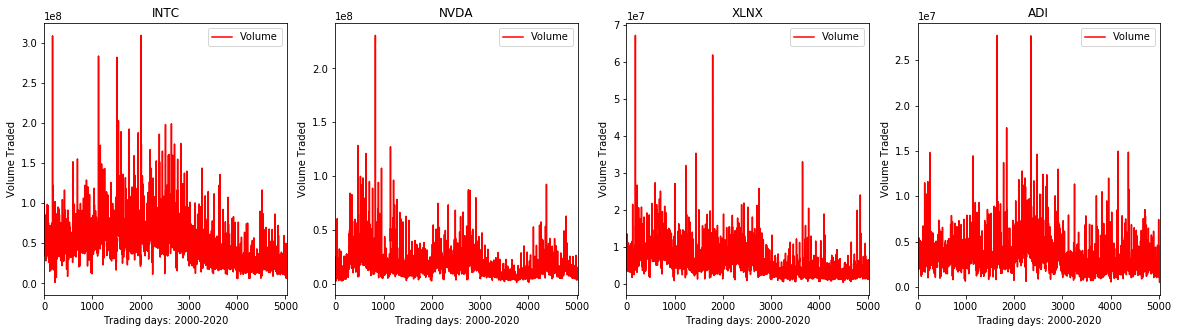

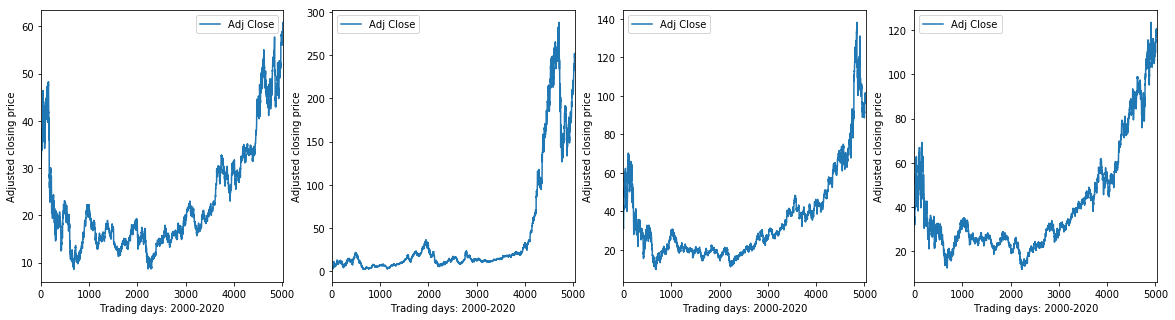

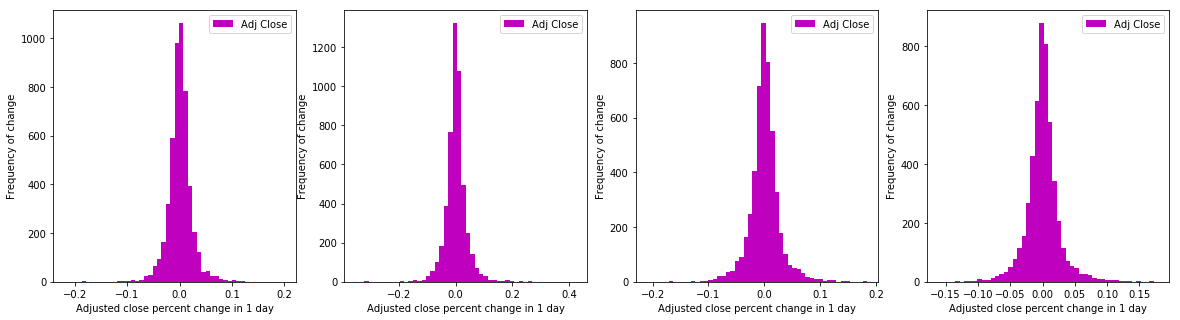

<Figure size 432x288 with 0 Axes>

In [4]:
#Code to produce raw plots 

# set width of plots
ww = 20
#set height of plots
hh = 5

# list of keys
keys = list(d_stocks.keys()) 

#list of values
values = list(d_stocks.values())

#create and populate subplots
plt.subplots_adjust(wspace=.2, hspace=.2)
plt.figure(figsize=(ww, hh))

# first row
for i in range(len(keys)):
    plt.subplot(1, len(keys), i+1)
    values[i]['Volume'].plot(label='Volume', color='r', title = keys[i], legend=True)
    #intc_df['Adj Close'].plot(label='INTC', legend=True)
    plt.ylabel('Volume Traded')
    plt.xlabel('Trading days: 2000-2020')
    
plt.show()  # show the plot
#plt.clf()  # clear the plot space for the next plot

# second row
plt.figure(figsize=(ww, hh))
for i in range(len(keys)):
    plt.subplot(1, len(keys), i+1)
    values[i]['Adj Close'].plot(label='Adj Close', legend=True)
    plt.ylabel('Adjusted closing price')
    plt.xlabel('Trading days: 2000-2020')
    
plt.show()  # show the plot
#plt.clf()  # clear the plot space for the next plot

# third row
plt.figure(figsize=(ww, hh))
for i in range(len(keys)):
# Histogram of the daily price change percent of Adj_Close
    plt.subplot(1, len(keys), i+1)
    values[i]['Adj Close'].pct_change().plot.hist(bins=50, color='m', legend=True)
    plt.xlabel('Adjusted close percent change in 1 day')
    plt.ylabel('Frequency of change')
    
plt.show()  # show the plot
plt.clf()  # clear the plot space for the next plot
del i # clear the index

## 3) Preliminary Analysis
To answer the next three questions, you may find it useful to write a few lines of code that use some built-in pandas [methods](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) for working with dataframes, such as [.max()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.max.html#pandas.DataFrame.max), [.min()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.min.html#pandas.DataFrame.min), and perhaps even [idxmax](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.idxmax.html#pandas.DataFrame.idxmax) and [idxmin](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.idxmin.html#pandas.DataFrame.idxmin). For Question 3, you might find both [pct_change()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pct_change.html#pandas.DataFrame.pct_change) and [.var()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.var.html#pandas.DataFrame.var) useful.


Both Question 1 and Question 2 require you to give a list and dictionary, whereas Question 3 is a multiple choice, multiple answer question. 

___

## Question 1

What is the correct ordering of stocks by maximum volume, from highest to lowest? Complete the function `ans_one()` with your answer. Specifically, you need to find the maximum volume of each stock then order the stocks by their respective maximum trading volumes, from highest volume to lowest.  

Provide two lines of code to specify the variables `d_list` and `d_max`: 

~~~python
d_list =   # a list, ordered max volume to min volume
d_max =   # a dictionary, ordered max volume to min volume
~~~
___

In [56]:
def ans_one():
    """ Returns a list of stocks ordered by volume
        and a dictionary ordered by volume. 
    
    Parameters
    ----------
    :d_list:  list
        The list of stock names ordered by volume,  max to min
    :d_max:   dictionary
        The dictionary of stocks ordered by volume, max to min
    
    Returns
    -------
    :d_list:
    :d_max:
    """

        # YOUR CODE HERE
    lst = []

    # list appending of all stock max values
    for i in range(len(values)):

          lst.append(np.max(values[i]['Volume']))

    d_max =  dict( zip( keys, lst)) #dict created for zipping values
    d_list = sorted(d_max.items(), key=lambda x:x[1]) #Sorting values in list
    #d = [x[1] for x in d_list][::-1]
    d_list = [x[0] for x in d_list][::-1] #Reversed order as we wanted in descending order
    #d_max = dict(zip(d_list,d))

    #print(d_max,d_list)

    
    #raise NotImplementedError()
    return d_list, d_max

In [57]:
# Test cell

In [58]:
# Test cell
d_list, d_max = ans_one()
if (type(d_list) == list and type(d_max) == dict):
    assert True
else: 
    print("ERROR: Check that `d_list` is a list, and `d_max` a dictionary")
    raise AssertionError("Type error: executing ans_one() should return a list and dict")

['INTC', 'NVDA', 'XLNX', 'ADI'] {'ADI': 27748000, 'NVDA': 230771400, 'XLNX': 67156700, 'INTC': 309347600}


TypeError: 'NoneType' object is not iterable

In [8]:
# Test cell

___

## Question 2

What is the correct ordering of stocks by their maximum Adjusted Closing Price, from highest to lowest? 

Complete the function `ans_two()` with your answer. Specifically, you need to provide two lines of code specify the variables `d_ans` and `d_max`: 

~~~python
d_ans =   # a list, ordered Adjusted Closing Price, max to min
d_max =   # a dictionary, Adjusted Closing Price, max to min
~~~

The grader will evaluate adjusted closing price rounded to two decimal places using Python's built-in [round](https://docs.python.org/3/library/functions.html#round) function. 
___

In [9]:
def ans_two():
    """ Returns a list of stocks ordered by Adjusted Closing Price
        and a dictionary ordered by Adjusted Closing Price. 
    
    Parameters
    ----------
    :d_list:  list
        The list of stock names ordered by Adj Close,  max to min
    :d_max:   dictionary
        The dictionary of stocks ordered by Adj Close, max to min
    
    Returns
    -------
    :d_list:
    :d_max:
    """
    # YOUR CODE HERE
    
    lst = []

    # list appending of all stock max values
    for i in range(len(values)):

          lst.append(np.max(values[i]['Adj Close']))

    d_max =  dict( zip( keys, lst)) #dict created for zipping values
    d_list = sorted(d_max.items(), key=lambda x:x[1]) #Sorting values in list
    #d = [x[1] for x in d_list][::-1]
    d_list = [x[0] for x in d_list][::-1] #Reversed order as we wanted in descending order
    #d_max = dict(zip(d_list,d))

    #print(d_max,d_list)

    #raise NotImplementedError()
    return d_list, d_max

In [10]:
# Test cell

In [11]:
# Test cell
d_list, d_max = ans_two()
if (type(d_list) == list and type(d_max) == dict):
    assert True
else: 
    print("ERROR: Check that `d_list` is a list, and `d_max` a dictionary")
    raise AssertionError("Type error: executing ans_one() should return a list and dict")

In [12]:
# Test cell

---
## Question 3

Each stock has a peak price, $P_1$, which you calculated to answer Question 2. Following $P_1$, there is a minimum price or trough, $T$.  Following $T$ there may be another peak, $P_2$, called the <b>rebound price</b>. For purposes of the next question we say that the <b>rebound recovery percentage</b> <i>(RRP)</i> of a stock is calculated by 

$$ RRP := \frac{P_2}{P_1} $$

which is 1.00 if $P_2 = P_1$.

Which of the following are true? Select all and only that apply.  

* A) None of the stocks have seen their closing price drop more than 50% after their peak price. 

* B) ADI has the highest rebound recovery.

* C) XLNX has the highest rebound recovery.

* D) NVDA has the highest variance in one-day percentage price change.

* E) INTC has the lowest variance in one-day percentage price change.

* F) None of the above are true

From the list of possible answers `['A', 'B', 'C', 'D', 'E', 'F']`, complete the next function with a list of your answer(s).

---

# For Question 2
RRP = [] # For storing RRP values of each stock
Price =[]  # For storing Price of each stock
li = [df_adi,df_intc,df_nvda,df_xlnx] # For Looping over elements

#Iterarating over loop
for a in li:
    l = [a['Adj Close'][i] for i in range(0,len(a))]
    P = np.argmax(l)
    p1 = np.max(l)
    l = l[P:]
    T = np.argmin(l)
    t = np.min(l)
    l = l[T:]
    p2 = np.max(l)
    Price.append(np.var((a['Adj Close'].shift(1)) / a['Adj Close']))
    RRP.append(p2 / p1)

l = ['adi','intc','nvda','xlnx'] # For creating dict to seevalues
RRP_Stock = dict(zip(l,Price)) # For Storing RRP
Price_Stock = dict(zip(l,RRP)) # For Storing Price Stock
#print(RRP_Stock,Price_Stock)

In [13]:
def ans_three():
    """ Returns a list of your answers.  
    
    Parameters
    ----------
    :ans:  list
        The list of your answers. Elements of :ans: are strings.
    Returns
    -------
    :ans:
    """
    
    # YOUR CODE HERE
    
    
    ans = ['D','E']
    
    
    #raise NotImplementedError()
    return ans

In [14]:
# Test cell

In [15]:
# Test cell
ans = ans_three()
possible_ans = ['A', 'B', 'C', 'D', 'E', 'F']
if type(ans) == list and all(ii in possible_ans for ii in ans):
    assert True
else:
    print("Error: Check that your answer, " + repr(ans) + ", is admissible and the correct format.")
    raise AssertionError("Inadmissible answer.")

# II. Predicting Movement

In this section you will run two classification models on the smoothed data, then do some feature engineering and rerun the same two models on your stock data with those features.  

Your task then is to compare the performance of predicting the movement of your stocks using a logistic regression model and a random forest model.

## 4) Exponential Smoothing
The first step is to preprocess data by <b>exponential smoothing</b>.  The smoothed statistic $s_t$ at time $t$ is an  function of the current observation, $x_t$, and previous observations $x_{t-1}, x_{t-2},\ldots, x_0$, and the smoothing factor $\alpha$: 

$$ s_t = \frac{x_t + (1-\alpha)x_{t-1}+(1-\alpha)^2x_{t-2}+\cdots+(1-\alpha)^tx_0}{1+(1-\alpha)+(1-\alpha)^2 + \cdots + (1-\alpha)^t}$$

This equation is the [adjusted version](https://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#exponentially-weighted-windows) of the exponential weighted window for finite histories, which is the default used by `emw()`.  The smoothing factor $\alpha$ takes values between $0$ and $1$ (excluding 0), where it should be clear that $s_t = x_t$ if $\alpha = 1$, which corresponds to no smoothing.

The next cell perform some data preparation steps for you. We delete the feature `Date`, because we will simply use an integer index to preserve the time order, and delete the feature `Adj Close`. Movement in the opening price in `Open` will be the target variable we wish to predict.


In [16]:
# remove 'Date' and 'Adj Close' features from each stock dataframe 
for key, value in d_stocks.items():
    # 
    del(value['Date'])
    del(value['Adj Close'])

Your next task is to finish the function, `exp_smooth()`, using the pandas [.ewm method()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html) and [.mean()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html)  to calculate <b>exponential weighted average</b> of a dataframe.  

The `ewm()` method has a number of adjustable parameters, but for this task you should only use the smoothing factor $\alpha$, which takes values between 0 and 1. To be explicit, your use of this method should be of the following form:

~~~python
df.ewm(alpha=alpha)
~~~
applied here to some data frame `df`.


The `mean()` method also has a number of parameters, but you should not use any (i.e., leave the parentheses blank to use the default parameter values).

For this task, you need to attend to two things.  First, to complete the function, you need to supply one line of code to compute exponential smoothing to `df`, a datframe, assigned to the local variable `smoothed_df`: 

~~~python

smoothed_df =  ## finish your line of code here

~~~

Second, the smoothing factor default value (when one is not specified) is set to 1/2:

~~~python
alpha=0.5
~~~

Values for `alpha` (using a variable named `ta_alpha`, below) will be adjusted by you later in the assignment.

In [17]:
def exp_smooth(df, alpha=0.5):
    """ Returns the exponential weighted average of a dataframe 
    
        Parameters
        ----------
        :df: dataframe
            The input dataframe 
        :alpha: float
            The smoothing factor|
            
        Returns
        -------
        :smoothed_df: dataframe
            The exponential weighted average of df with smoothing alpha
    """ 
    
    # YOUR CODE HERE
    smoothed_df = df.ewm(alpha = alpha).mean()
    #raise NotImplementedError()
    return smoothed_df


In [18]:
# public test condition: the exponential weighted average of the
# Opening price of ADI on day 1000 with default alpha = 0.5 rounded
# to 3 decimal places is 48.823:

if round(exp_smooth(df_adi)['Open'][1000], 3) == 48.823:
    assert True
else:
    print("Error: Check that your exp_smooth() function is implemented correctly.")
    raise AssertionError("Incorrect answer.")

## 5) Direction-Prediction with Logistic Regression and Random Forests

In this part, you will construct two models that predict the direction of stock prices realizing a gain ($y = 1$) or loss ($y=0$). Specifically, you will compare the performance of a logistic regression classifier, which you have worked with already, to an ensemble of CART classification models, otherwise known as a <b>random forest</b> classifier.

Predicting returns is typically posed as a forecasting regression problem, where prices are predicted. The problem may nevertheless be posed as a classification problem which predicts whether a stock price will increase or decrease.  The model you will develop here is adapted from an approach taken by ([Basak, Kar, Saha, Khaidem, and Dey 2019](https://www.sciencedirect.com/science/article/abs/pii/S106294081730400X?via%3Dihub)), and is markedly different than standard time-series methods:


<div class="alert alert-block alert-success">
"Standard models used in stock price forecasting involves statistical methods such as time series modeling and multivariate analysis ... where the stock price movements are usually treated as a function of time and solved as a regression problem. Conversely, in this paper as we pose it as a classification problem, the class label of each sample is determined by considering the t-day return. In our analysis, we have conducted experiments on t = 3, 5, 10, 15, 30, 60, and 90 days. The goal is to design an intelligent model that learns from the market data using machine learning techniques and predicts the direction in which a stock price will change at the closing time everyday. The ability to forecast direction of stock prices for individuals and companies capable of holding on to investments over medium to long-run should be a very useful support to this literature" (Basak et al. 2019, p. 553).
</div>



From this point on, you will be modifying your stock data frames, by adding new columns (features), and later, for step 6, smoothing the original data with different values of the smoothing factor $\alpha$.  The next code cell collects together some code to be run all at once under a particular value for alpha in an effort to help ensure that smoothing is <i>only applied once</i>. 


<div class="alert alert-block alert-info">
<b>Tip:</b> Because you are making modifications to your datasets, it is a good idea to clear and rerun the notebook as you complete each task to make sure your code runs without errors from the start.</div>


In [19]:
# Copy stock dataframes
adi = df_adi
intc = df_intc
nvda = df_nvda
xlnx = df_xlnx

# Stock dictionary used for smoothing and feature engineering.
s_stock_d = {'ADI': adi, 'INTC': intc, 'NVDA': nvda, 'XLNX': xlnx}

# smoothing factor
alpha = .5

# apply smoothing to all stocks in dict
for key, value in s_stock_d.items():
        s_stock_d[key] = exp_smooth(value,alpha)

Your next task is to compare the closing price from $n$-days ago to the current closing price. If the $n$-day ago price is greater than or equal to the current price, then `pred = 1`; otherwise, `pred = 0`.  

To effect this comparison, you may wish to use the [.shift(-n)](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html), where $n$ is an integer used to specify the number of trading days the index will be shifted.  For example, you may wish to compare

~~~python
adi.shift(-1)['Close']
~~~
to
~~~python
adi['Close']
~~~

to see the output.

Your task is to write one line of code to produce a Series consisting of a column of 1's and 0's, saved to the local variable `pred`, that will serve as your vector of classification labels. In other words, `pred` stores $y^{(i)} = 1$ or $y^{(i)} = 0$ for each day.

~~~python
    pred =  #YOUR CODE HERE    # Hint: returns 0 if a loss
    pred = pred.iloc[:-n]
    return pred.astype(int)
~~~

In [20]:
def prediction_int(df, n):
    """ Returns an integer label for n day closing price losses/gains.
    
    Parameters
    ----------
    :df:     dataframe
        A stock dataframe
    :n:      int
        The prediction horizon in days
    
    Returns
    -------
    :data:   series
        The single column of integer predictions: 0 is a predicted loss, 1 otherwise.
    """
    # YOUR CODE HERE
    pred = [] #For storing Pred Values
    a = df.shift(-n)['Close']  #Shifting values
    b = df.Close
    pred = pd.Series([1 if a[i] > b[i] else 0  for i in range(len(df))]) #Checking conditions
    
    #raise NotImplementedError()
    pred = pred.iloc[:-n]
    #print(pred)
    return pred.astype(int)

In [21]:
# Test cell 
if prediction_int(intc,8)[265] == 1:
    assert True
else:
    raise AssertionError("The function predict_int is not implemented correctly.")

In [22]:
def prepare_data(df, days):
    """ Adds prediction vector and prepares data
    
    Parameters
    ----------
    :df:     dataframe
        A stock dataframe
    :days:   int
        The prediction horizon in days
    
    Returns
    -------
    :data:   dataframe
    """
    
    data = df.dropna().iloc[:-days]
    data['pred'] = prediction_int(data, n=days)
    del(data['Close'])
    return data.dropna()

Here is a block of code that operates on a single data frame `df = s_stock_d['ADI']` and a particular time window `days = 7` to produce a target vector of 1s and 0s, `y = data['pred']`, and the features of the `data` without labels, `X = data.drop('pred',axis =1)`:

~~~python
#prepare ADI stock data with 7 day forecast window
data = prepare_data(s_stock_d['ADI'], 7)

# create target label vector
y = data['pred']

# create features by removing the target labels
X = data.drop('pred',axis =1)

~~~
You will be asked, below, to evaluate <i>all</i> stocks. So, it will be more efficient to write some code using [iterators](https://wiki.python.org/moin/Iterator) to generalize this preparation step to prepare all stocks in the dictionary `s_stocks_d`. The next cell should be used to write complete such a function.


In [23]:
def features_targets_dict(d, days):
    """ Prepares a dictionary that stores the target Series y 
        and features Dataframe X with a prediction window (days)
        for dictionary of stock Dataframes (d)
    
    Parameters
    ----------
    :d:     dictionary
        A dictionary of stocks whose values are dataframes
    :days: int
        The prediction horizon in days
    
    Returns
    -------
    :datasets:    dictionary of labaled datasets for each stock
    :targetsets:  dictionary of target label vectors for each stock
    :featuresets: dictionary of unlabeled datasets for each stock
    """

    # dictionary data prep
    datasets = {}
    targetsets = {}
    featuresets = {}
    for k in d.keys():
        datasets[k] = prepare_data(d[k],days)
        # YOUR CODE HERE
        targetsets[k] = datasets[k].iloc[:,-1]
        featuresets[k] = datasets[k].iloc[:,:-1]
        #raise NotImplementedError()
    return datasets, targetsets, featuresets

<div class="alert alert-block alert-info">
    <b>Important:</b> The next test cells for <b>features_targets_dict()</b> assume that <b>alpha = 0.5</b>. The public test conditions will produce an error if you preprocess your data with a different value for alpha.
</div> 

In [24]:
# Test cell
# features_targets_dict() test
datasets, targetsets, featuresets = features_targets_dict(s_stock_d, 7)
if round(datasets['ADI']['Open'][55], 3) == 74.289  and round(datasets['NVDA']['Open'][555], 3) == 13.884:
    assert True
else:
    print("Hint: check that you are iterating over all the stock dataframes")
    raise AssertionError("Error in features_targets_dict()")

if targetsets['ADI'].isnull().values.any() == False:
    assert True
else:
    print("Your targetset contains NaNs. Hint: Try using the .dropna() method.")
    raise AssertionError("Error in targetsets")

### SK-Learn
Recall the workflow logic and API format for sklearn.  To review, briefly, once libriaries are imported, you should prepare your data, split into test and training sets, fit a model, perform predictions on a test set, then evaluate the results with appropriate numerical performance measures.

To help you, here is some code that will run on a <i>single dataframe</i>.  Given the questions you will be asked to consider, you will want to adapt this to iterate over all items of your stock dictionary, and perhaps even iterate over the models.  Ideally, you should collect together the results of your model in a single dataframe that stores  all the results in one table.  What you choose to do, however, is up to you.

### Sample code for producing a Random Forest Model.


<img src="ps3_fig4.png" alt="frankfurt school hmi" style="width: 900px;"/>


### Important for Your Implementation:
 - For a Logistic Regression model, replace 

~~~python
clf = RandomForestClassifier(n_jobs=-1, n_estimators=65, random_state=212)
~~~
with
~~~python
clf = LogisticRegression()
~~~

#### Note:
 - The exact parameters for `RandomForestClassifier` (i.e., `n_jobs = -1`, `n_estimators = 65`, `random_state = 212`), must be used.  You should not specify any parameters for `LogisticRegression()`. 

 - A 70/30 split must be used: it is strongly recommended to incorporate the following line of code to ensure a standardized split.
 
~~~python
train_set_split = int(len(X) * 0.7) 
~~~

<div class="alert alert-block alert-info">
    <b>Important:</b> To ensure standardized answers, you <b>must</b> use these parameter settings and only these settings.  In addition, we are continuing to use a 7-day window and `alpha = 0.5`.
</div> 

The next cell loads models and metrics from sklearn.

In [25]:
# libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, confusion_matrix, recall_score, accuracy_score

Using sklearn, you should build relevant models to answer the next and subsequent questions.

---
## Question 4

There are four stocks (ADI, INTC, NVDA, XLNX) and two classification models (Logistic Regression, Random Forest). Pre-process your data using a 7-day window and smoothing factor $\alpha = 0.5$. What is the ranking of the accuracy results (rounded to 3 decimal places) of the resulting 8 models, from best to worst?  

To answer this question, you will need to supply a dictionary whose <b>keys</b> are from the following list:

~~~python
# keys for the dictionary returned by ans_four()
['ADI LR','INTC LR', 'NVDA LR', 'XLNX LR', 'ADI RF','INTC RF', 'NVDA RF', 'XLNX RF']  
~~~
and whose <b>values</b> are the accuracy scores of each model, rounded to 3 decimal places.  To be clear, 'LR' denotes a logistic regression model and 'RF' a random forest model.  Thus, within the dictionary `d_acc` returned by `ans_four()`, `'ADI LR'` is the dictionary key value used to refer to the accuracy score of a logistic regression classification model for the ADI stock. Your answer to Question 4 will be two lines of code for `ans_four()`, one for the dictionary `d_acc` and another for the ordered list of stock names `ordered_stocks`. Each line has the following generic forms:

~~~python

d_ans = {'Key_1': 0.000, 'Key_2': 0.000, 'Key_3': 0.000, 'Key_4': 0.000,
         'Key_5': 0.000, 'Key_6': 0.000, 'Key_7': 0.000, 'Key_8': 0.000}

ordered_stocks = ['Key_of_highest','Key_2nd', 'Key_3rd', 'Key_4th','Key_5th',
                  'Key_6th', 'Key_7th', 'Key_of_lowest']
         
~~~

To avoid mistyped answers, you may wish to copy-and-paste each model's key name from the list of keys above.   To ensure your dictionary <b>values</b> pass the tests correctly, <b>your accuracy scores</b> that you enter in `d_ans` should be rounded to 3 decimal places using  

~~~python
# code that will be used to test your key values. 
round(acc, 3) 
~~~
wherel `acc` is the accuracy score for the corresponding model.

---

#For Question 4 and 5 and some parts of 6 with alpha value = 0.5
model_acc = ['INTC RF','INTC LR','NVDA RF','NVDA LR','XLNX RF','XLNX LR','ADI RF','ADI LR']
window = [7,10,14,21]
for w in window:
 l = [] #For checking accuracy
 r = [] #For checking recall
 p = [] #For checking precision
 f = [] #For checking fscore
 # Program to iteraate and check along
 for k in d_stocks.keys():
    
    #print(k)
    df = exp_smooth(d_stocks[k], alpha=0.5)
    df = prepare_data(df,7)
    X  = df.iloc[:,:-1]
    y =  df.iloc[:,-1]
    train_test_split = int(len(X) * 0.7)
    X_train = X[:train_test_split]
    X_test = X[train_test_split:]
    y_train = y[:train_test_split]
    y_test = y[train_test_split:]
    clf = RandomForestClassifier(n_jobs=-1, n_estimators=65, random_state=212)
    clf.fit(X_train,y_train)
    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_pred = pred,y_true = y_test)
    recall =recall_score(y_pred = pred,y_true = y_test)
    precision = precision_score(y_pred = pred,y_true = y_test)
    f1 = f1_score(y_pred = pred,y_true = y_test)
    l.append(np.round(accuracy,3))
    r.append(np.round(recall,3))
    p.append(np.round(precision,3))
    f.append(np.round(f1,3))
    clf = LogisticRegression()
    clf.fit(X_train,y_train)
    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_pred = pred,y_true = y_test)
    accuracy = accuracy_score(y_pred = pred,y_true = y_test)
    recall =recall_score(y_pred = pred,y_true = y_test)
    precision = precision_score(y_pred = pred,y_true = y_test)
    f1 = f1_score(y_pred = pred,y_true = y_test)
    l.append(np.round(accuracy,3))
    r.append(np.round(recall,3))
    p.append(np.round(precision,3))
    f.append(np.round(f1,3))
    
 print("**************")
 print(" For Window %d"%w)

 print("**************")
 print("Accuracy")
 d_acc = dict(zip(model_acc,l)) #For checking accuracy
 print(d_acc)
     #print(l)

 print("Recall")
 rec = dict(zip(model_acc,r)) #For checking recall
 print(rec)

 print("Precision")
 pr = dict(zip(model_acc,p)) #For checking precision
 print(pr)

 print("F1 Score")
 f = dict(zip(model_acc,f)) #For checking f1 score
 print(f)


print("*******")




In [33]:
def ans_four():
    """ Returns a dictionary ordered by accuracy. 
    
    Parameters
    ----------
    :d_acc:   dictionary
        The dictionary of stocks and thier accuracy score to 3 decimal places
    
    :ordered_stocks:   list
        The list of string names ordered by their accuracy score to 3 decimal places, max to min
    Returns
    -------
    :d_acc:
    :ordered_stocks:
    """
    # YOUR CODE HERE
    
    d_acc = {'ADI RF': 0.43, 'NVDA LR': 0.609, 'ADI LR': 0.564, 'XLNX RF': 0.509, 'INTC RF': 0.495, 'NVDA RF': 0.416, 'XLNX LR': 0.543, 'INTC LR': 0.425}

    ordered_stocks = ['NVDA LR', 'ADI LR', 'XLNX LR', 'XLNX RF','INTC RF','ADI RF', 'INTC LR','NVDA RF']
    
    #raise NotImplementedError()
    return d_acc, ordered_stocks

In [34]:
# Test cell

In [35]:
# Test cell
d_acc, ordered_stocks = ans_four()
if (type(d_acc) == dict and len(d_acc) == 8):
    assert True
else: 
    print("ERROR: Check that `d_acc` is a dictionary with 8 items.")
    raise AssertionError("Error: ans_four()")

if (type(ordered_stocks) == list and len(ordered_stocks) == 8):
    assert True
else: 
    print("ERROR: Check that `ordered_stocks` is a list with 8 items and correctly ordered")
    raise AssertionError("Error: ans_four()")

---
## Question 5
Multiple choice questions. Use the same model parameters as for Question 4: a 7-day window and smoothing factor $\alpha = 0.5$. 

Select all and only that are true.

 - A) A random forest model produces the lowest F1 score
 - B) NVDA Logistic Regression has the highest Accuracy, Precision, Recall, and F1 Score.  In other words, there is no other stock whose scores are strictly greater than NVDA's scores.  
 - C) All random forest models have a precision score greater than 0.5.
 - D) No random forest model has an F1 score greater than 0.5.
 - E) NVDA is the stock whose F1 score is the most sensitive to model choice (i.e., the stock whose F1 scores differ the <b>most</b> wrt Logistic Regression and Random Forests given the parameter settings.)  
 - F) XLNX is the stock whose Precision score is the least sensitive to model choice (i.e., the stock whose Precision scores differ the <b>least</b> wrt Logistic Regression and Random Forests given the parameter settings.

From the list of possible answers `['A', 'B', 'C', 'D', 'E', 'F']`, complete the next function with a list of your answer(s).

---

In [36]:
def ans_five():
    """ Returns a list of your answers.  
    
    Parameters
    ----------
    :ans:  list
        The list of your answers. Elements of :ans: are strings.
    Returns
    -------
    :ans:
    """
    
    # YOUR CODE HERE
    ans = ['B','D','E','F']
    #raise NotImplementedError()
    return ans

In [37]:
# Test cell
ans = ans_five()
possible_ans = ['A', 'B', 'C', 'D', 'E', 'F']
if type(ans) == list and all(ii in possible_ans for ii in ans):
    assert True
else:
    print("Error: Check that your answer, " + repr(ans) + ", is admissible and the correct format.")
    raise AssertionError("Inadmissible answer.")

## 6) Feature Engineering with Technical Indicators

In this section of the assignment you will prepare new features for your stock data using a range of technical indicators.  The next cell imports a library of technical indicators, followed by a brief description of those you will use to add features to your stock dataframes. 

In [38]:
# technical indicators
import pandas_technical_indicators as ta

### Technical Indicators 
Technical indicators use price and volume information to identify statistical trends from historical trading activity to predict future movements in price or volume.  Common indicators used to forecast price movement include:

(1) <b>Relative strength index ([RSI](https://www.investopedia.com/terms/r/rsi.asp))</b>,  (Wilder 1978): is a  momentum  indicator that compares bullish or bearish price momentum of an asset to its price.  The RSI oscillates between 0 and 100, where values of 70 or greater indicates  overbought conditions and values of 30 or less indicate underbought conditions. 

(2) <b>Stochastic Oscillator  ([OS](https://www.investopedia.com/terms/s/stochasticoscillator.asp))</b>, (Lane 1984): is a  momentum  indicator  that compares a security's closing price to a historical window of past prices.  The range of OS values is between 0 and 100.

(3) <b>Williams percentage range ([%R](https://www.investopedia.com/terms/w/williamsr.asp))</b>, (Williams 1978): is a  momentum  indicator that indicates the level of a closing price in relation to the highest price for stock within a 14-day look-back period. 

(4) <b>Moving average convergence divivergence ([MACD](https://www.investopedia.com/terms/m/macd.asp))</b>, (Appel 2005): is a  momentum  indicator that compares the 26-day exponential moving average (EMA) to the 12-day EMA.  The MCAD is the difference between the 26-day EMA and 12-day EMA.

(5) <b>Price rate of change ([PROC](https://www.investopedia.com/terms/p/pricerateofchange.asp))</b>, (Larson 2015): is a momentum-based oscillator that measures the percentage change between the current price and the price over a period of time.  In finance the acronym 'ROC' is used.  However, in machine learning, 'ROC' refers to [receiver operating characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curve. We use PROC here to avoid ambiguity.

(6) <b>On balance volume ([OBV](https://www.investopedia.com/terms/o/onbalancevolume.asp))</b>, (Granville 1963): is a momentum indicator that uses the flow of volume to estimate changes in price.  The indicator keeps a running total of trading volume, accumulating volume on days when the price increases, subtracts volume on days when prices decrease.

(7) <b>Accumulation distribution line ([ADI](https://www.investopedia.com/terms/a/accumulationdistribution.asp))</b>, (Chaikin 2002): detects divergences between price and volume flow to predict the strength of a trend. 

(8) <b>Money Flow Index ([MFI](https://www.investopedia.com/terms/m/mfi.asp))</b>  (Quong and Soudack 1989) This is a  volume-weighted RSI, similar to the ADI in using volume flow and price to identify overbought or oversold conditions.

(9) <b>Average True Range ([ATR](https://www.investopedia.com/terms/a/atr.asp))</b> (Wilder 1978): measures market volitility, typically over a 14 day moving average.


(10) <b>Triple Exponential Average ([TREMA or TRIX](https://www.investopedia.com/articles/technical/02/092402.asp))</b>, (Hutson 1983) takes multiple exponential moving averages to identify short-term changes in price direction.

(11) <b>Vortex Indicator ([VI](https://www.investopedia.com/terms/v/vortex-indicator-vi.asp))</b> (Botes and Siepman 2010) is designed to identify trend reversals and to confirm a current trend. 

(12) <b>Ease of Movement ([EoM or EVM](https://www.investopedia.com/terms/e/easeofmovement.asp))</b> (Arms 1999): is a volume-weighted momentum indicator that uses price volitility and volume to assess the "ease" versus "resistance" of price movement to discern how easily a price can move up or down.  

(13) <b>Commodity Channel Index ([CCI](https://www.investopedia.com/terms/c/commoditychannelindex.asp))</b> (Lambert 1980): is a momentum indicator used to assess price trend and direction. 

---

The next cell is a function, called `technical_features()`, that computes several technical indicators for a range of time windows (5, 14, 26, 44, and 66 day periods) and adds these computed values as feature columns to a stock dataframe.   

This function is complete: you only need to run it. However, it is recommended that you study `technical_features()` to understand what it is doing for you.


In [39]:
def technical_features(df):
    """ adds technical features from pandas_technical_indicators 
        to a dataframe for 5, 14, 26, 44, and 66 day periods
    
    Parameters
    ----------
    :df:  pandas DataFrame
        a data frame of stocks
    
    Returns
    -------
    :df:  pandas DataFrame
        the dataframe df with new features and without Open, High, Low, and Volume
    """
    for period in [5, 14, 26, 44, 66]:
        df = ta.relative_strength_index(df, n=period)   #rsi
        df = ta.stochastic_oscillator_d(df, n=period)   #so
        df = ta.accumulation_distribution(df, n=period) #adl
        df = ta.average_true_range(df, n=period)        #atr
        df = ta.momentum(df, n=period)                  #mom
        df = ta.money_flow_index(df, n=period)          #mfi
        df = ta.rate_of_change(df, n=period)            #proc or roc
        df = ta.on_balance_volume(df, n=period)         #obv
        df = ta.commodity_channel_index(df, n=period)   #cci
        df = ta.ease_of_movement(df, n=period)          #eom
        df = ta.trix(df, n=period)                      #trix
        df = ta.vortex_indicator(df, n=period)          #vi
    
    df = ta.macd(df, n_fast=12, n_slow=26)              #macd
    
    df['ema50'] = df['Close'] / df['Close'].ewm(50).mean()   #ema 50 days
    df['ema21'] = df['Close'] / df['Close'].ewm(21).mean()   #ema 21 days
    df['ema14'] = df['Close'] / df['Close'].ewm(14).mean()   #ema 14 days
    df['ema5'] = df['Close'] / df['Close'].ewm(5).mean()     #ema  5 days
    
    # remove 
    del(df['Open'])
    del(df['High'])
    del(df['Low'])
    del(df['Volume'])
    
    return df

The next cell modifies the `prepare_data()` function, from above, to add the technical indicator features to each stock dataframe using `technical_features()`.

It is recommended that you study `ta_prepare_data()` to understand what it is doing.

In [40]:
def ta_prepare_data(df, days):
    """ Adds prediction vector and prepares data with technical features
    
    Parameters
    ----------
    :df:     dataframe
        A stock dataframe
    :days:   int
        The prediction horizon in days
    
    Returns
    -------
    :data:   dataframe
    """
    
    data = technical_features(df).dropna().iloc[:-days]
    data['pred'] = prediction_int(data, n=days)
    del(data['Close'])
    return data.dropna()

<b>Your next task</b> is to complete the function `ta_features_targets_dict()`, which modifies a dictionary `d` of stock dataframes by adding the technical features to each stock dataframe in `d`, and returning three dictionarys: `datasets`, a dictionary of labeled datasets for each stock; `targetsets`, a dictionry of target label vectors for each stock; `featuresets`, a dictionary of unlabeled datasets for each stock.  The code for computing `datasets` is complete, but the code for `targetsets` and `featuresets` is missing.  Your task is to write two lines of code, one for `targetsets` and the other for `featuresets`.  There should be no `NaN` or "missing values" in either dictionary. 

You may find the pandas methods [drop()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) and [dropna()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html?highlight=dropna)  helpful. 



In [41]:
def ta_features_targets_dict(d, days):
    """ Prepares a dictionary that stores the target Series y 
        and technical features to Dataframe X with a prediction 
        window (days) for dictionary of stock Dataframes (d)
    
    Parameters
    ----------
    :d:     dictionary
        A dictionary of stocks whose values are dataframes
    :days: int
        The prediction horizon in days
    
    Returns
    -------
    :datasets:    dictionary of labaled datasets for each stock
    :targetsets:  dictionary of target label vectors for each stock
    :featuresets: dictionary of unlabeled datasets for each stock
    """

    # dictionary data prep
    datasets = {}
    targetsets = {}
    featuresets = {}
    for k in d.keys():
        datasets[k] = ta_prepare_data(d[k],days)
        # YOUR CODE HERE
        targetsets[k] = datasets[k].iloc[:,-1]
        featuresets[k] = datasets[k].iloc[:,:-1]
        #raise NotImplementedError()
    return datasets, targetsets, featuresets

### Adjusting Alpha
In the next cell, you will have an opportunity to change the values of $\alpha$.  Because it is important in the first half of the assignment that `alpha = 0.5`, you will adjust a parameter called `ta_alpha`.  Specifically, in the next cell you will see

~~~python
ta_alpha = 0.2
~~~
which can be adjusted to take values between 0 and 1, 0 excluded.

In [42]:
# Copy stock dataframes
adi = df_adi
intc = df_intc
nvda = df_nvda
xlnx = df_xlnx

# Stock dictionary used for smoothing and feature engineering.
s_stock_d = {'ADI': adi, 'INTC': intc, 'NVDA': nvda, 'XLNX': xlnx}

# adjust alpha here: values should be greater than 0 and less than 1
ta_alpha = 0.2

# apply smoothing to all stocks in dict
for key, value in s_stock_d.items():
        s_stock_d[key] = exp_smooth(value,ta_alpha)

The next cell plots a comparison between unsmoothed and smoothed data sets to help guide intuitions about the effect of different values of the smoothing factor, $\alpha$.   

<Figure size 432x288 with 0 Axes>

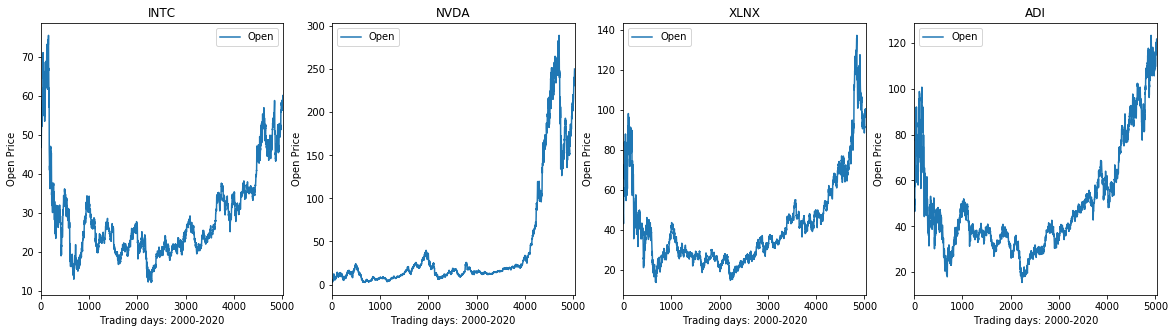

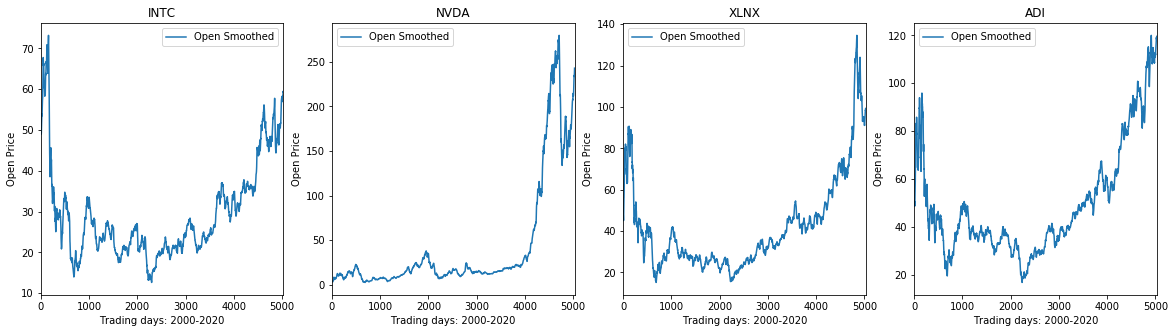

In [43]:
ww = 20
hh = 5

s_keys = list(s_stock_d.keys())
s_values = list(s_stock_d.values())

plt.subplots_adjust(wspace=.2, hspace=.2)
plt.figure(figsize=(ww, hh))
for i in range(len(s_keys)):
    plt.subplot(1, len(keys), i+1)
    values[i]['Open'].plot(label='Open', title = keys[i], legend=True)
    plt.ylabel('Open Price')
    plt.xlabel('Trading days: 2000-2020')
    
plt.subplots_adjust(wspace=.2, hspace=.2)
plt.figure(figsize=(ww, hh))
for i in range(len(keys)):
# Plot the Adj Close columns 
    plt.subplot(1, len(keys), i+1)
    s_values[i]['Open'].plot(label='Open Smoothed', title = keys[i], legend=True)
    plt.ylabel('Open Price')
    plt.xlabel('Trading days: 2000-2020')
    
plt.show()  # show the plot

In [44]:
# Test cell

#For Question 6 with alpha 0.2
# For differenr models
model_acc = ['INTC RF','INTC LR','NVDA RF','NVDA LR','XLNX RF','XLNX LR','ADI RF','ADI LR']
#For diffrent days of window
window = [7,10,14,21]
# For storing keys
keys = s_stock_d.keys()
# Program to iterate and check along
for w in window:
 l = [] #For checking accuracy
 r = [] #For checking recall
 p = [] #For checking precision
 f = [] #For checking fscore
 for k in keys:
    #print(k)
    df = s_stock_d[k] #for different days
    df = prepare_data(df,w)
    X  = df.iloc[:,:-1]
    y =  df.iloc[:,-1]
    train_test_split = int(len(X) * 0.7)
    X_train = X[:train_test_split]
    X_test = X[train_test_split:]
    y_train = y[:train_test_split]
    y_test = y[train_test_split:]
    clf = RandomForestClassifier(n_jobs=-1, n_estimators=65, random_state=212)
    clf.fit(X_train,y_train)
    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_pred = pred,y_true = y_test)
    recall =recall_score(y_pred = pred,y_true = y_test)
    precision = precision_score(y_pred = pred,y_true = y_test)
    f1 = f1_score(y_pred = pred,y_true = y_test)
    l.append(np.round(accuracy,3))
    r.append(np.round(recall,3))
    p.append(np.round(precision,3))
    f.append(np.round(f1,3))
    clf = LogisticRegression()
    clf.fit(X_train,y_train)
    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_pred = pred,y_true = y_test)
    accuracy = accuracy_score(y_pred = pred,y_true = y_test)
    recall =recall_score(y_pred = pred,y_true = y_test)
    precision = precision_score(y_pred = pred,y_true = y_test)
    f1 = f1_score(y_pred = pred,y_true = y_test)
    l.append(np.round(accuracy,3))
    r.append(np.round(recall,3))
    p.append(np.round(precision,3))
    f.append(np.round(f1,3))
    
 print("**************")
 print(" For Window %d"%w)

 print("**************")
 print("Accuracy")
 d_acc = dict(zip(model_acc,l)) #For checking accuracy
 print(d_acc)
     #print(l)

 print("Recall")
 rec = dict(zip(model_acc,r)) #For checking recall
 print(rec)

 print("Precision")
 pr = dict(zip(model_acc,p)) #For checking precision
 print(pr)

 print("F1 Score")
 f = dict(zip(model_acc,f)) #For checking f1 score
 print(f)


print("*******")




---
## Question 6
Multiple choice questions. Select all and only that are true.

 - A) All things considered, a smaller alpha generally improves accuracy scores for all stocks.
 - B) For $\alpha = 0.2$ (i.e., `ta_alpha = 0.2`), the F1 score for each model with a 7-day window is greater than the corresponding model's F1 score with a 14-day window.
 - C) For some $\alpha$, all random forest models have a precision score greater than 0.5 in 7-day, 14-day, and 21-day window horizons.
 - D) For some $\alpha$, no logistic regression model has an accuracy score above 0.5 in a 10-day window horizon.
 - E) NVDA is the stock whose F1 score is the most sensitive to model choice for 10-day window models with alpha = 0.5 (i.e., NVDA is the stock whose F1 scores differ the <b>most</b> wrt Logistic Regression and Random Forests given a 7-day, 10-day, 14-day, and 21-day horizon window  with `ta_alpha = 0.5`).  
 - F) The maximum difference in F1 score between Logistic Regression and Random Forests decreases as the n-day window horizon increases, for n = 7, 10, 14, 21, all compared with a constant alpha of 0.5 (that is, `ta_model = 0.5`).

From the list of possible answers `['A', 'B', 'C', 'D', 'E', 'F']`, complete the next function with a list of your answer(s).

---

In [50]:
def ans_six():
    """ Returns a list of your answers.  
    
    Parameters
    ----------
    :ans:  list
        The list of your answers. Elements of :ans: are strings.
    Returns
    -------
    :ans:
    """
    
    # YOUR CODE HERE
    ans = ['A','E','F']
    #raise NotImplementedError()
    return ans

In [51]:
# Test cell
ans = ans_six()
possible_ans = ['A', 'B', 'C', 'D', 'E', 'F']
if type(ans) == list and all(ii in possible_ans for ii in ans):
    assert True
else:
    print("Error: Check that your answer, " + repr(ans) + ", is admissible and the correct format.")
    raise AssertionError("Inadmissible answer.")

---
## Question 7

There are 8 data points. Each observation is labeled either P, for positive class ($y =1)$, or N, for negative class ($y=0)$. Suppose that you have a binary classifier that produces a probability estimate for each observation belonging to the positive class. The eight data points are then ordered, from highest probability of that data point belonging to the positive class to lowest probability, yielding the following ordering: 

$$\mathrm{PNPPNNPN}$$

There are several ways to divide our ordered list of observations into two groups, those the model predicts are in the positive class and those the model predicts are all in the negative class.  This decision boundary may be determined by the probability threshold, which we symbolize by $\wedge$.

Which threshold or thresholds yields a precision of 1/2?  Select all and only that are true.

  - A) $\mathrm{PN_{\wedge}PPNNPN}$
  - B) $\mathrm{PNP_{\wedge}PNNPN}$
  - C) $\mathrm{PNPP_{\wedge}NNPN}$
  - D) $\mathrm{PNPPN_{\wedge}NPN}$
  - E) $\mathrm{PNPPNN_{\wedge}PN}$
  - F) $\mathrm{PNPPNNP_{\wedge}N}$
  
Given your answer, which is true?

  - G) Recall is guaranteed to be greater than 1/2.
  - H) Recall is guaranteed to be less than 1/2.
  - I) Recall may be greater than or less than 1/2.
  
From the list of possible answers `['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']`, complete the next function with a list of your answer(s).


In [52]:
def ans_seven():
    """ Returns a list of your answers.  
    
    Parameters
    ----------
    :ans:  list
        The list of your answers. Elements of :ans: are strings.
    Returns
    -------
    :ans:
    """
    
    # YOUR CODE HERE
    ans = ['A','E','I']
    #raise NotImplementedError()
    return ans

In [ ]:
# Test cell
ans = ans_seven()
possible_ans = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
if type(ans) == list and all(ii in possible_ans for ii in ans):
    assert True
else:
    print("Error: Check that your answer, " + repr(ans) + ", is admissible and the correct format.")
    raise AssertionError("Inadmissible answer.")

# III. Analysis


The core of the model you developed is taken from ([Basak, Kar, Saha, Khaidem, and Dey 2019](https://www.sciencedirect.com/science/article/abs/pii/S106294081730400X?via%3Dihub)), where they state:


<div class="alert alert-block alert-success">
"The focus of the current paper is ... to implement random forests, and gradient boosted trees on stock data, and to discuss its advantages over non-ensemble techniques" (Basak et al. 2019, p. 554).
</div>

A key step in their approach is the use of exponential smoothing as a preprocessing step, and you investigated the effect of using different values for the smoothing factor $\alpha$ for this preprocessing step in the assignment. 

<div class="alert alert-block alert-success">
"In the current work, we have used exponential smoothing to remove random local variation in the data. A detailed survey of the existing literature does not offer this as a preprocessing step to earlier predictions"  (p.558) </div>
 
Basak et al. report very accurate results, and the argue that the good performance of their methodology is due primarily to ensemble methods, like random forests, working better on non-linear stock data than linear (metric) classifiers, like logistic regression. 

<div class="alert alert-block alert-success">   
"The current methodology performs better than linear classifiers and the reason for this is the inherent non-linearity in the data. Our learning model to [sic] surpass all these metric classifiers in terms of long term prediction" (pp. 558-559).
</div>

## 7) Short Answer (2 points)
Do you agree with their analysis? If so, state why. If not, state why not.  

You should limit your answer to one paragraph (~100 to 200 words).  Your answer should be correct, concise, well-reasoned, and clearly written.  

 I agree with this technique of using Ensembling technique of random forest is better as the very core concept of this models is bootstrapping technique of using weak classifiers and building upon it while logistic regression has decision boundaries which works well only when data is preprocessed.Logistic Regression is working well in this case as noises from the data is removed and in linear world the decion boundaries are not difficult to attain. But in the case of highly noisy data and intricacies of data needs to be simplified which is calculated rightly by tree based models. The weighted average when calculated with  exponential average yields to  linearity which makes decision tree based model more apt in these both cases.Thus using gradient boosting and random forest model would be greatful to generalise the model and yield better resuts.





In [ ]:
# Test for Collaborator policy before submission
%run -i 'collaboration_test.py'

Before submitting this notebook, you should do the following steps:

<div class="alert alert-block alert-danger">
    0. <b>Delete Any New Code You Introduced</b>: You are likely to have written some code that is computationally expensive, taking many seconds or even some minutes to run.  If so, your notebook is very likely to <b>fail</b> the <b>second validation</b> test if you submit the assignment without first removing all new substantive code blocks introduced by you.  What's substantive?  If you see: $$\mathtt{In}\ [ * ]:$$ next to a running cell for more than a few seconds.
</div>
  
  1. __Restart Kernel__ (Kernel ⟶ Restart and Clear Output)
  2. __Run all Cells__ (Cell ⟶ Run All)
  3. __Validate__: Press the 'Validate' button above.
  4. __Save File__ (File ⟶ Save and Checkpoint)
  5. __Close and Shutdown Kernel__ (File ⟶ Close and Halt)